In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'

# lattice spacing and parameter

In [3]:
hbarc = 0.197e3 # MeV fm
lat_unit = 0.1 # 0.1 fm
ainv = hbarc/lat_unit

# generate mock-up data

We consider the mock-up data given by
\begin{equation}
R(t) = b_0 e^{-\Delta E_\mathrm{BB} t} + b_1 e^{-(\delta E_\mathrm{el} + \Delta E_\mathrm{BB})t}
+ c_0 e^{-(\delta E_\mathrm{inel} + \Delta E_\mathrm{BB})t}
\end{equation}
where the ground state energy shift $\Delta E_\mathrm{BB}$, the gap of the first excited elastic state $\delta E_\mathrm{el}$,
and the gap of the lowest inelastic state $\delta E_\mathrm{inel}$.

In this example, we consider $b_1/b_0 = \pm 0.1, 0$ and $c_0/b_0 = 0.01$ with $\delta E_\mathrm{el} = 50$ MeV
and $\delta E_\mathrm{inel} = 500$ MeV.

In [4]:
def generate_mockup(ts, Eel=50, b1b0=0.1, Einel=500, c0b0=0.01, sigma0=1.0e-4, sn_fac=0.3, Nsample=1000, seed=0):
    """
    Return effective energy shifts with fluctuations.
    (We neglect the correlation of the data for simplicity.)
    
    Parametrs:
    ts : np.ndarray
        Euclidean time
    Eel : float
        elastic state gap in MeV
    b1b0 : float
        contamination of the first excited elastic state (default = 0.1)
    c1b0 : float
        contamination of the lowest inelastic state (default = 0.01)
    sigma0 : float
        magnitude of the fluctuation
    sn_fac : float
        exponent of the growth of the noise
    Nsample : integer
        number of sampling to estimate the errors
    seed : integer
        seed for the random numbers
        
    Returns:
    Eeffs : np.ndarray
        the effective energy shifts
    Eeff_errs : np.ndarray
        the error of the effective energy shifts
    """
    np.random.seed(seed)
    R = lambda t: 1.0 + b1b0 * np.exp(-Eel*t/ainv) + c0b0 * np.exp(-Einel*t/ainv)
    sigma = lambda t: sigma0 * np.exp(sn_fac * t)
    Eeffs, Eeff_errs = [], []
    
    Ri = R(ts[0]) * (1.0 + sigma(ts[0]) * np.random.randn(Nsample))
    for t in ts:
        Rni = R(t+1) * (1.0 + sigma(t+1) * np.random.randn(Nsample))
        yi = np.log(Ri/Rni)
        Eeffs.append(yi.mean())
        Eeff_errs.append(yi.std() / np.sqrt(Nsample - 1))

        Ri = Rni # update correlator values
    return np.array(Eeffs), np.array(Eeff_errs)

In [5]:
def test_plot(Eel=50, b1b0=0.1, Einel=500, c0b0=0.01, yr=(-10, 10), seed=1):
    """
    test the behavior of the plateau for given parameters and random seed
    """
    fig, ax = plt.subplots()
    ts = np.arange(1, 24)
    
    Eeff, Eeff_err = generate_mockup(ts, b1b0=b1b0, c0b0=c0b0, seed=seed)
    ax.errorbar(ts * lat_unit, Eeff*ainv, Eeff_err*ainv,
               fmt='o', color='red', capsize=10, capthick=2,
               label=r'$c_0/b_0 = {:.2f}$, $b_1/b_0 = {:.2f}$'.format(c0b0, b1b0))
    
    ax.set_ylim(yr)
    ax.set_xlabel(r'$t$ [fm]', fontsize=48)
    ax.set_ylabel(r'$\Delta E_\mathrm{BB}^\mathrm{eff}(t) - \Delta E_\mathrm{BB}$ [MeV]',
                 fontsize=48)
    ax.axhline(0, c='black')
    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)


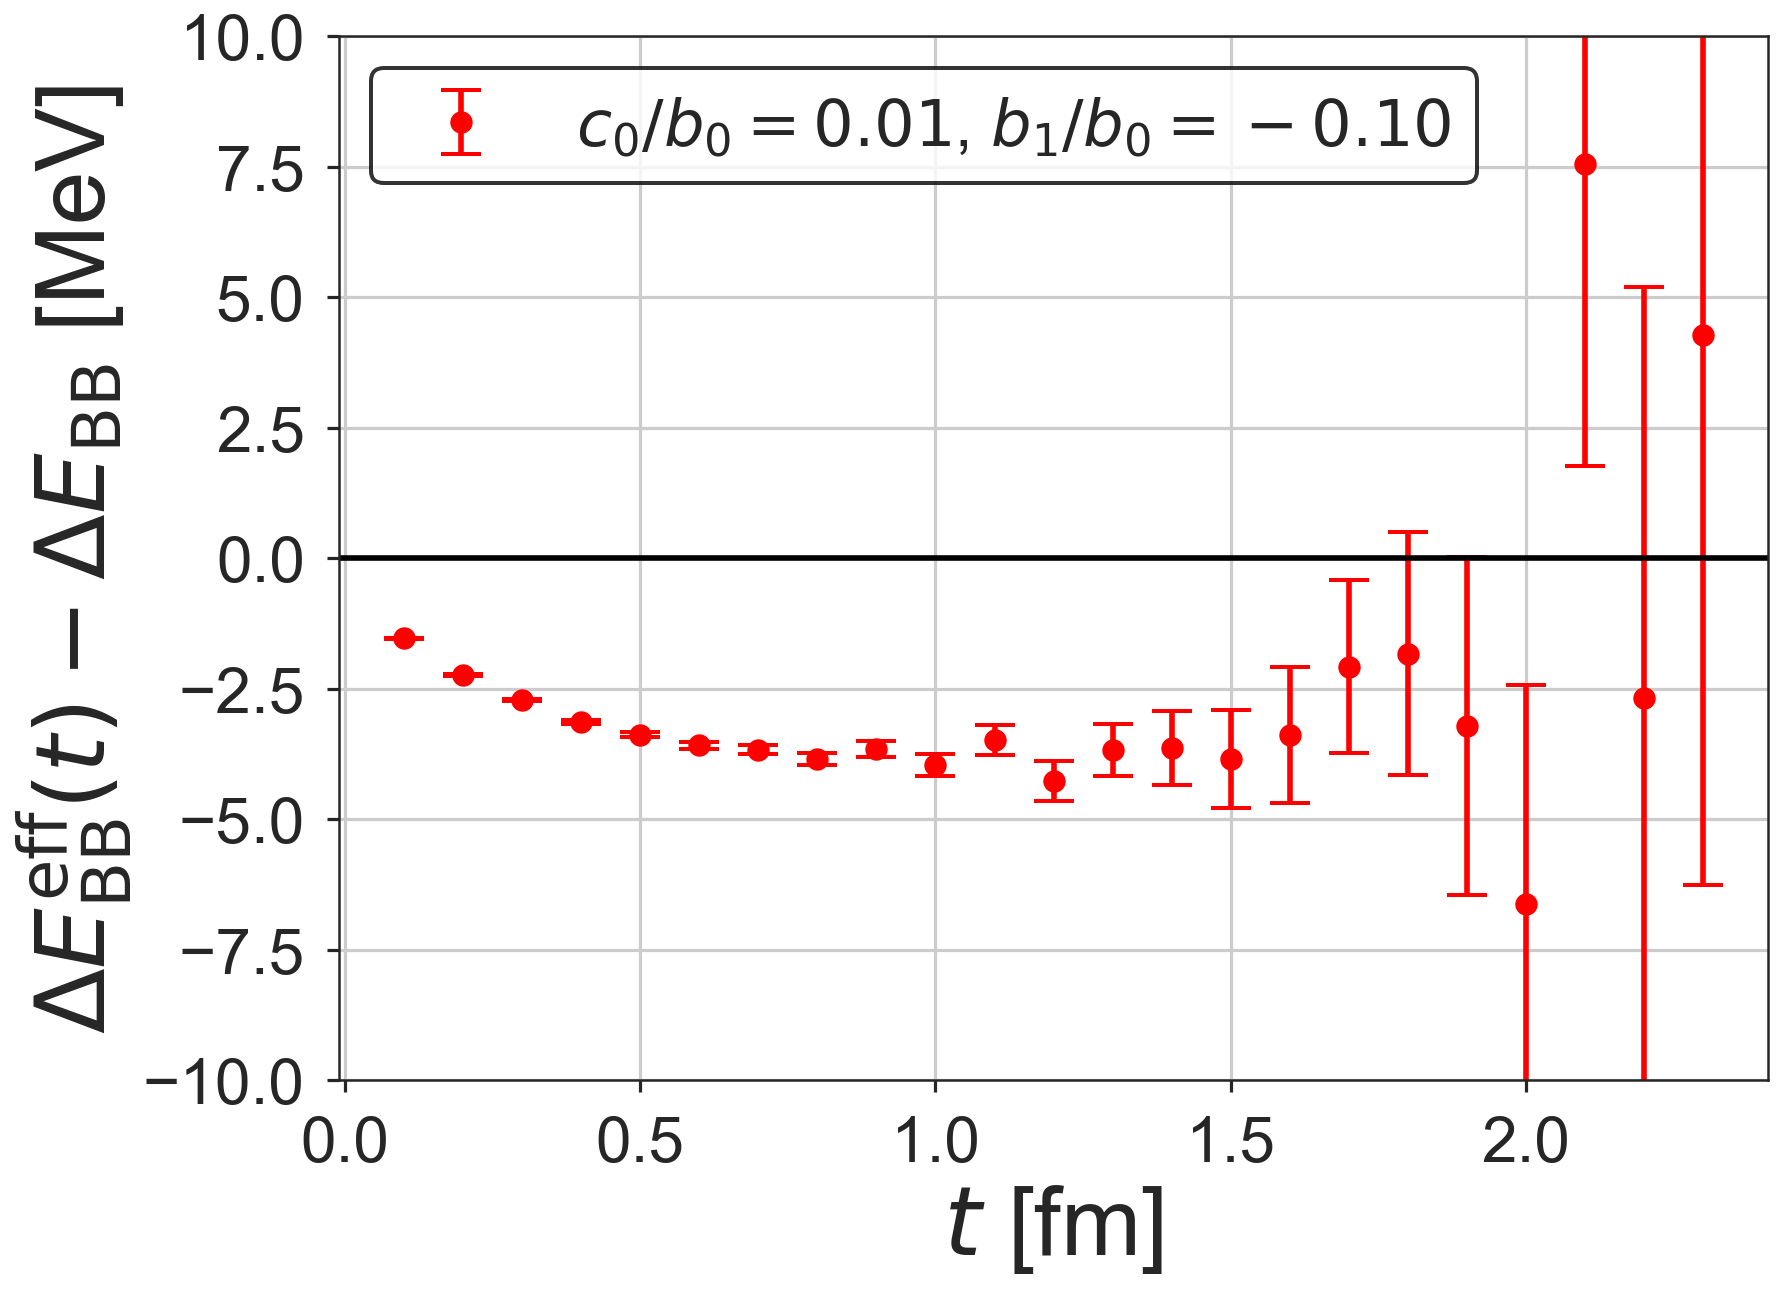

In [6]:
test_plot(b1b0= -0.1, seed=2)

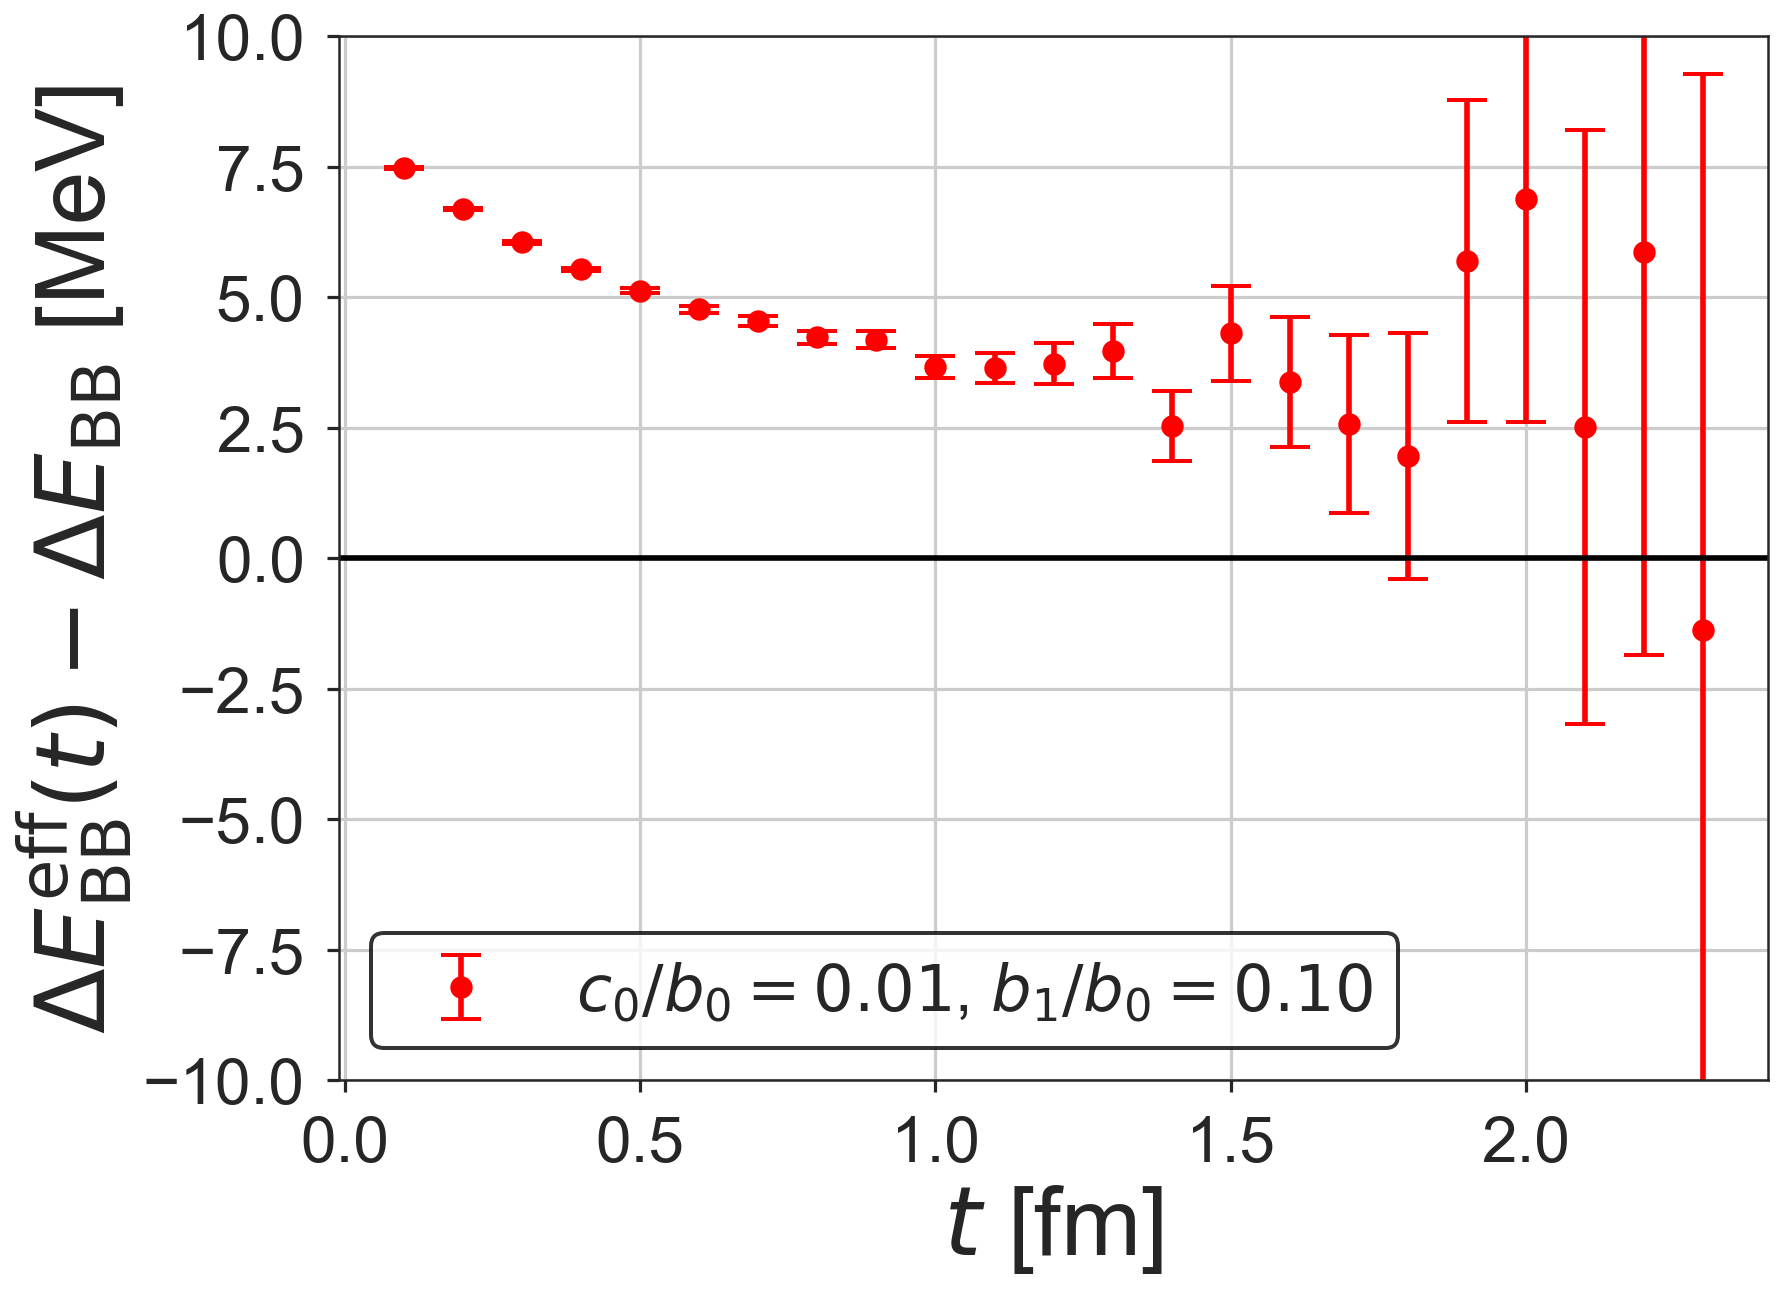

In [7]:
test_plot(b1b0= 0.1, seed=4)

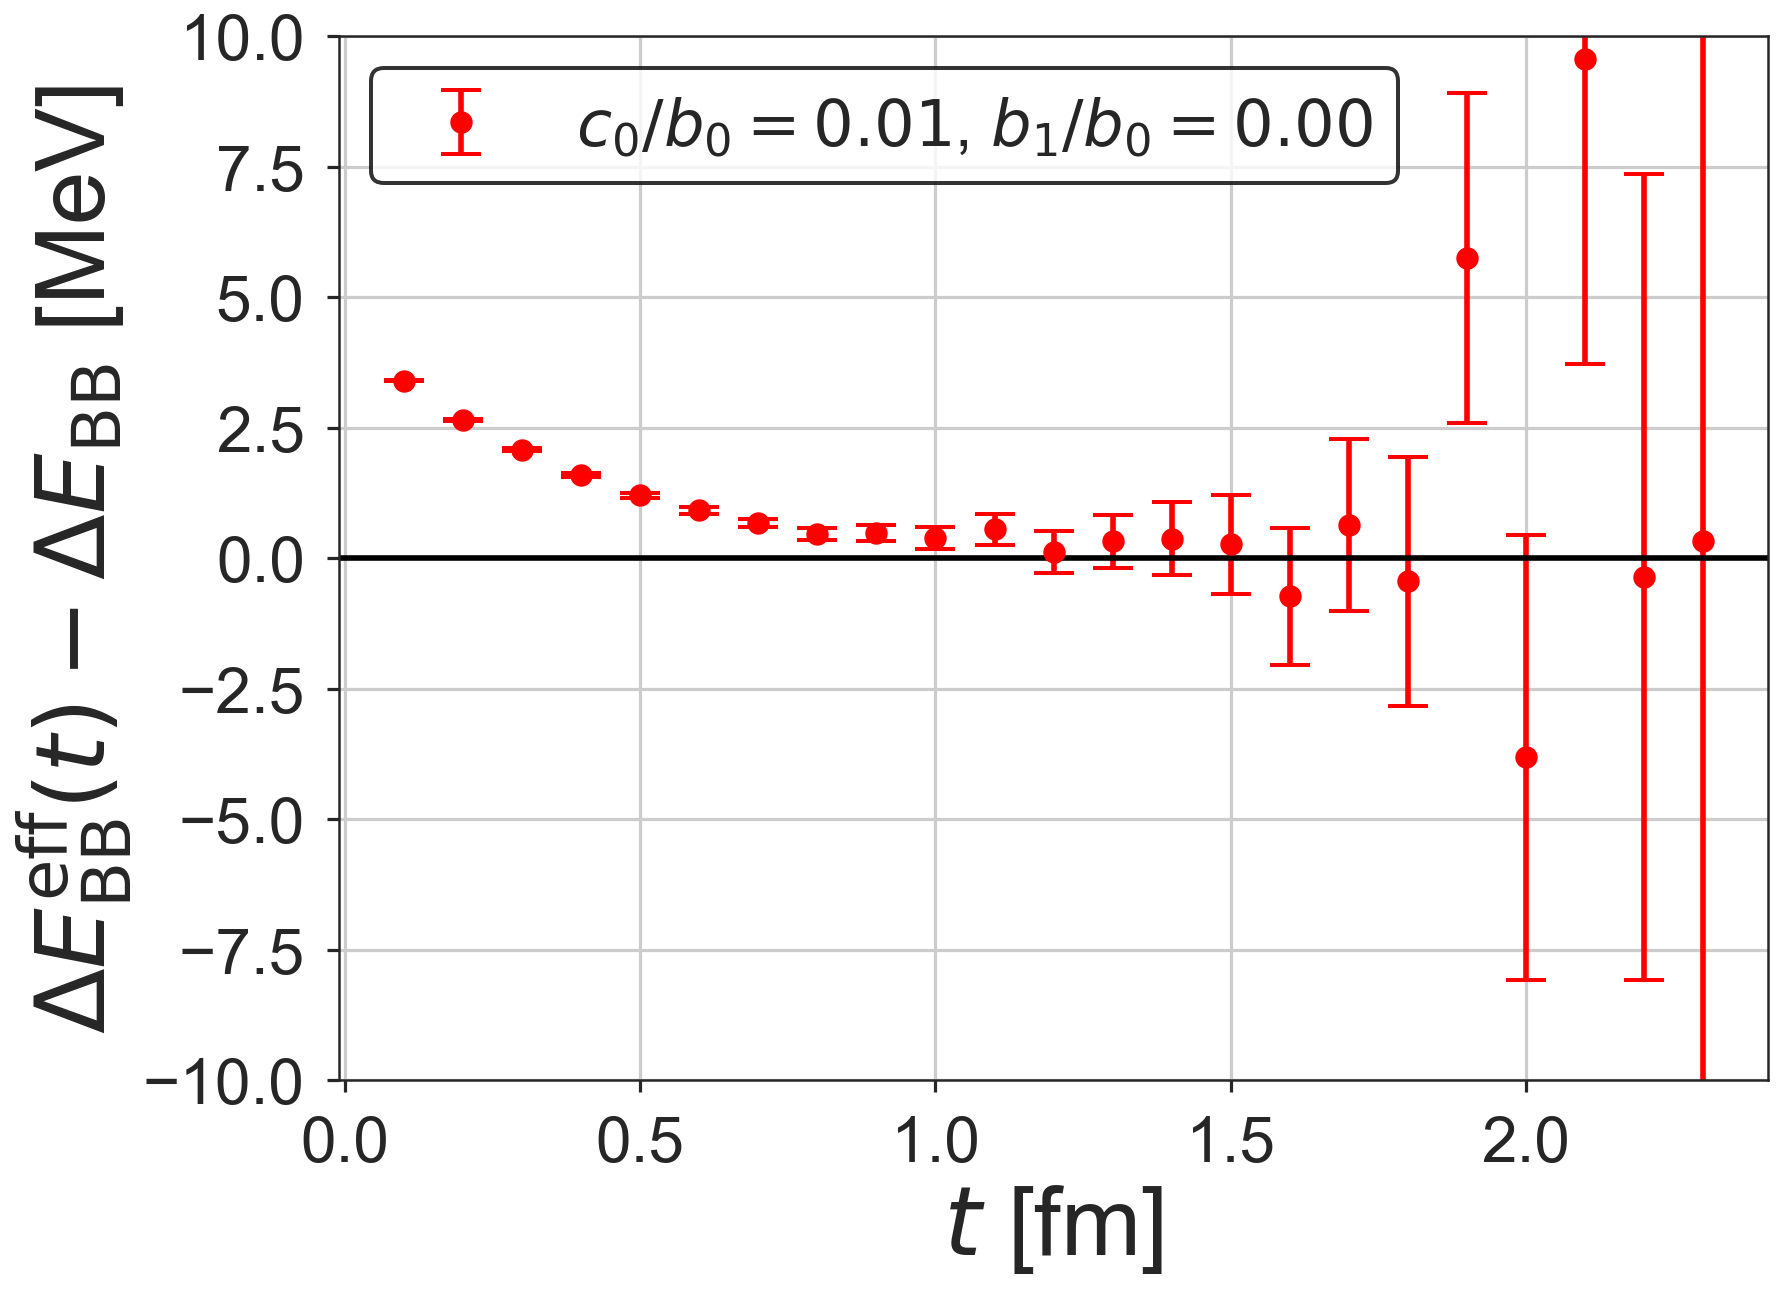

In [8]:
test_plot(b1b0= 0.0, seed=10)

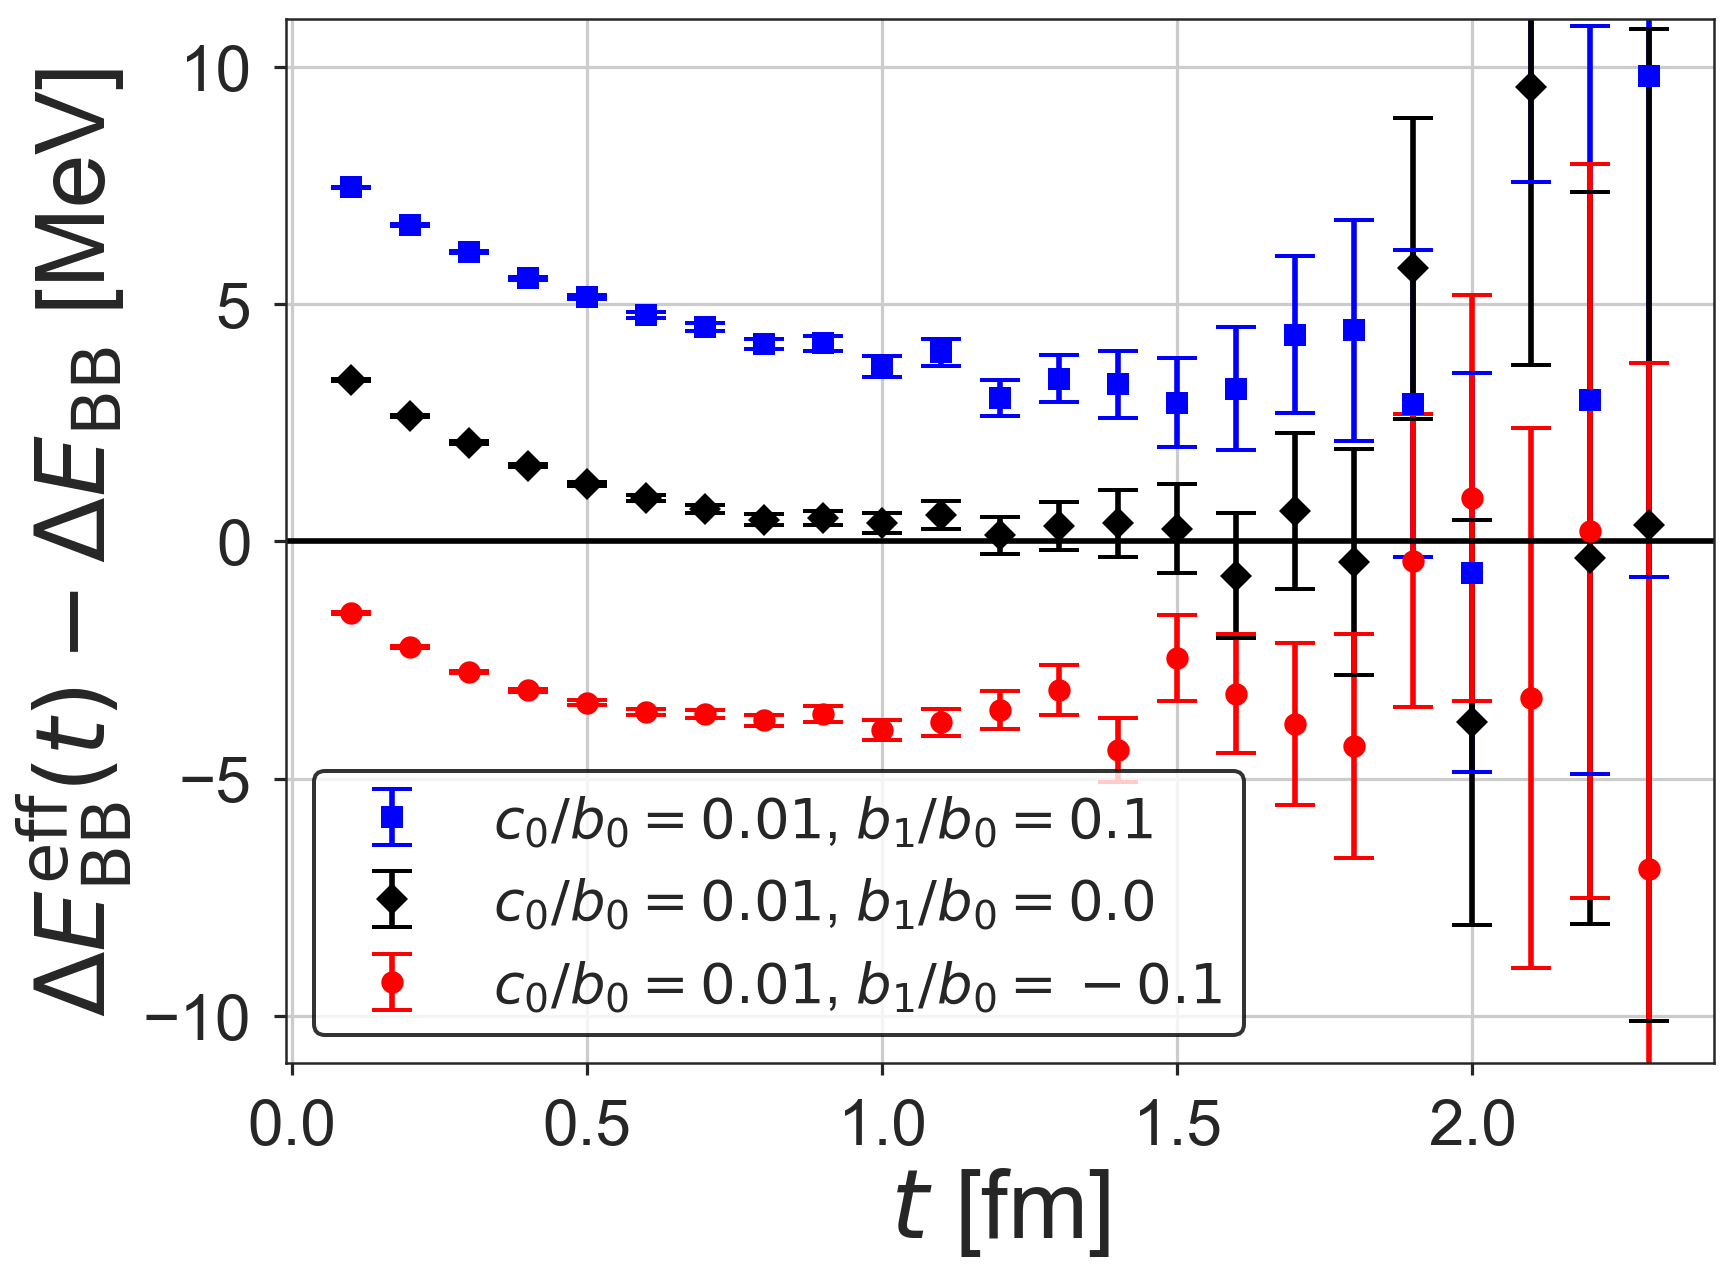

In [9]:
fig, ax = plt.subplots()
ts = np.arange(1, 24)
c0b0 = 0.01
for b1b0, seed, fmt, col in zip([0.1, 0, -0.1], [2, 10, 4], ['s', 'D', 'o'], ['blue', 'black', 'red']):
    Eeff, Eeff_err = generate_mockup(ts, b1b0=b1b0,seed=seed)
    ax.errorbar(ts * lat_unit, Eeff*ainv, Eeff_err*ainv,
               fmt=fmt, color=col, capsize=10, capthick=2,
               label=r'$c_0/b_0 = {:.2f}$, $b_1/b_0 = {:.1f}$'.format(c0b0, b1b0))
    
leg = ax.legend(frameon=True, fontsize=28)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_ylim(-11, 11)
ax.axhline(0, color='black')
ax.set_xlabel(r'$t$ [fm]', size=48)
ax.set_ylabel(r'$\Delta E_\mathrm{BB}^\mathrm{eff}(t) - \Delta E_\mathrm{BB}$ [MeV]', size=48);

# effective energy shift without noise

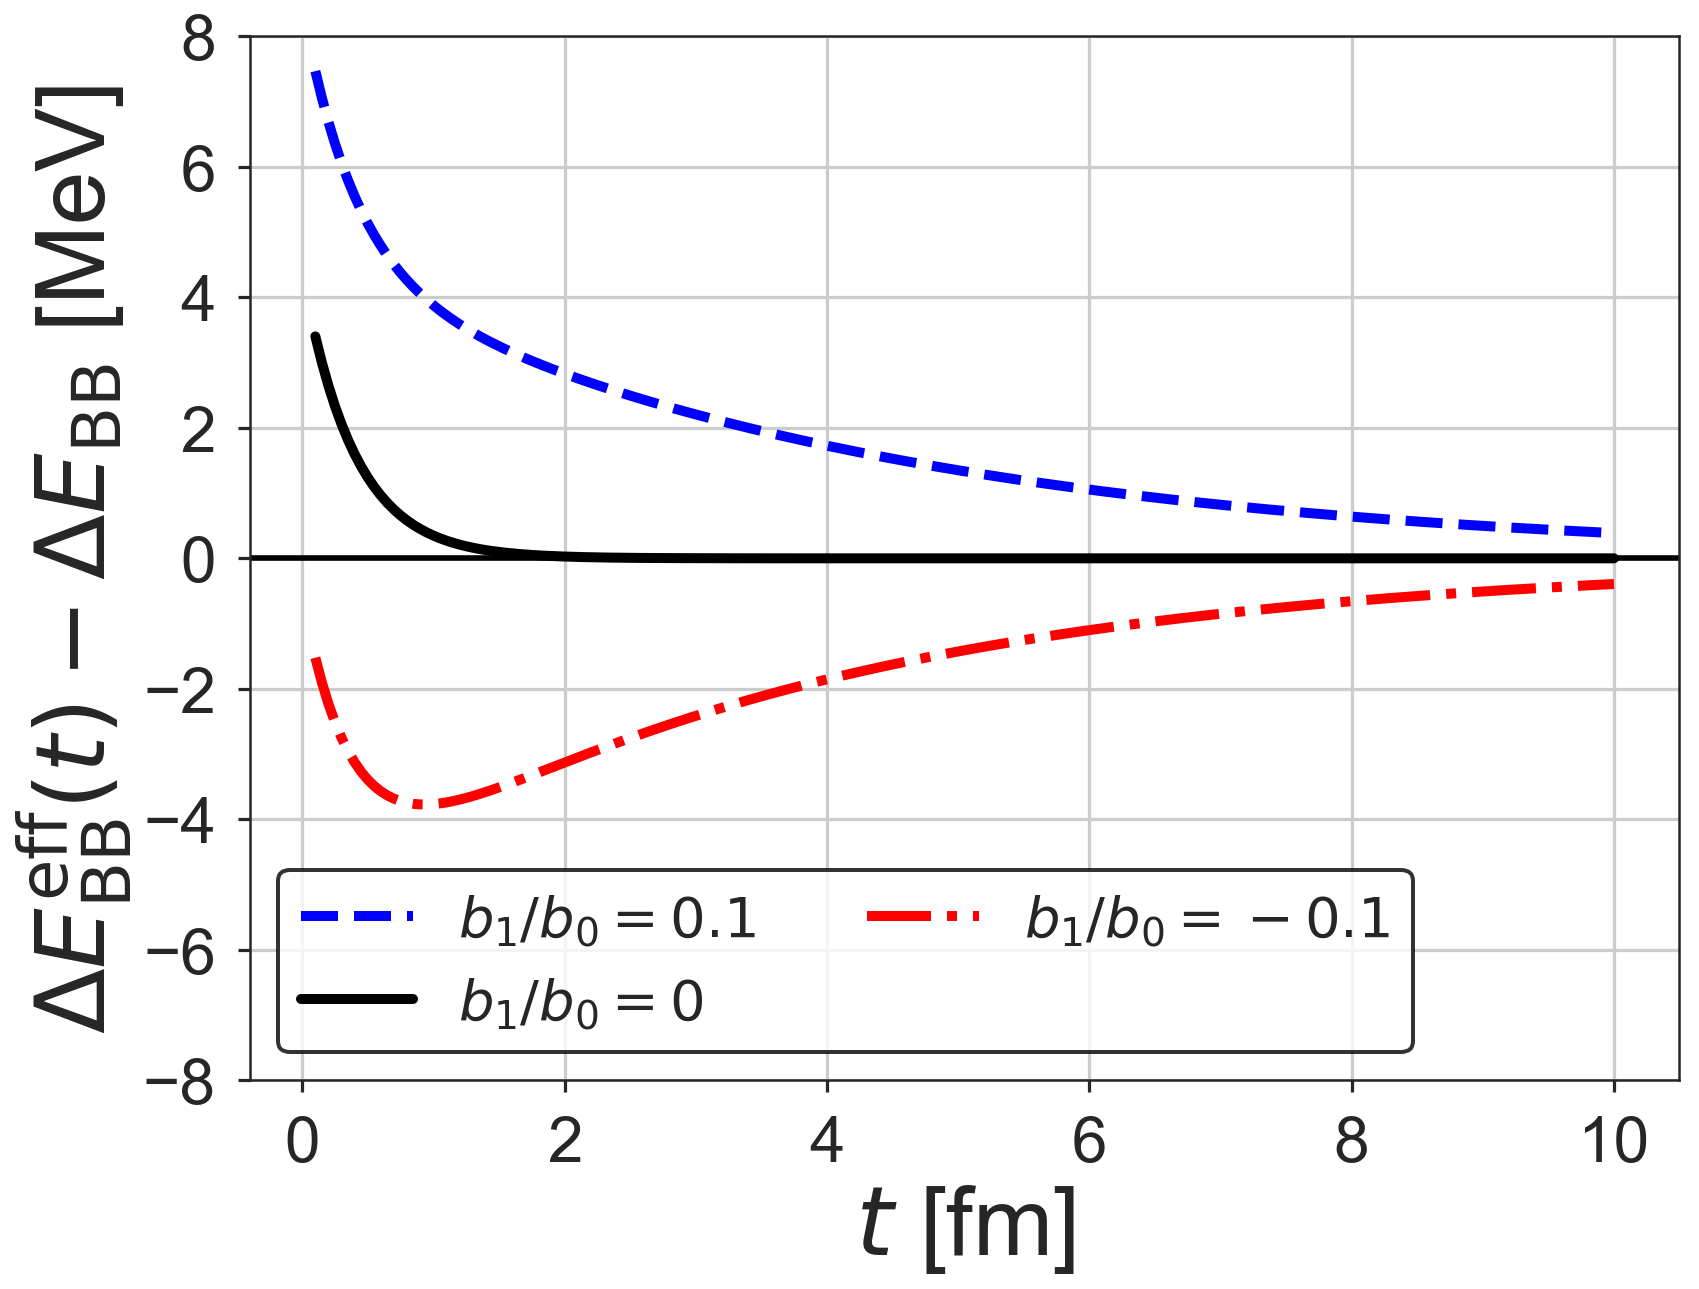

In [10]:
R = lambda b1b0, Eel, c0b0, Einel, t: 1.0 + b1b0*np.exp(-Eel*t) + c0b0*np.exp(-Einel*t)
dE_exact = lambda b1b0, Eel, c0b0, Einel, t: np.log(R(b1b0, Eel, c0b0, Einel, t)/R(b1b0, Eel, c0b0, Einel, t+1))

fig, ax = plt.subplots()

tls = np.linspace(1, 100, 200)
for b1b0, c, ls in zip([0.1, 0, -0.1], ['blue', 'black', 'red'], ['--', '-', '-.']):
    ex = dE_exact(b1b0, 50/ainv, 0.01, 500/ainv, tls)
    ax.plot(tls * lat_unit, ex* ainv, c=c, lw=5, linestyle=ls, label=r'$b_1/b_0 = {}$'.format(b1b0), zorder=3)
    
leg = ax.legend(loc='lower left', ncol=2, frameon=True, fontsize=28)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

ax.set_xlabel(r'$t$ [fm]', size=48)
ax.set_ylabel(r'$\Delta E_{\mathrm{BB}}^{\mathrm{eff}}(t) - \Delta E_{\mathrm{BB}}$ [MeV]', size=48)
ax.set_ylim(-8, 8)
ax.axhline(0, color='black');